In [14]:
! pip install kaggle

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:

! kaggle datasets download nikhilpandey360/chest-xray-masks-and-labels

Dataset URL: https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels
License(s): CC0-1.0
100% 9.58G/9.58G [07:23<00:00, 22.4MB/s]
100% 9.58G/9.58G [07:23<00:00, 23.2MB/s]


In [2]:
! unzip chest-xray-masks-and-labels.zip

Archive:  chest-xray-masks-and-labels.zip
  inflating: Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0001_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0002_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0003_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0004_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0005_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0006_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0007_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0008_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0009_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0010_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0011_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0012_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0013_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0014_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0015_0

In [3]:
import numpy as np
import pandas as pd
import matplotlib as plt
from tqdm import tqdm
import tensorflow as tf
import os
import cv2
from cv2 import imread, createCLAHE
from glob import glob


In [4]:
image_path = os.path.join("/content/Lung Segmentation/CXR_png")
mask_path = os.path.join("/content/Lung Segmentation/masks")

In [5]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [6]:
pwd

'/content'

In [7]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [8]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []

    if flag == "test":
        for i in tqdm(testing_files):
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

    if flag == "train":
        for i in tqdm(training_files):
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [9]:
# Load training and testing data
dim = 224
X_train, y_train = getData(dim, flag = 'train')
X_test, y_test = getData(dim, flag = 'test')

100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


In [10]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
from typing import Concatenate
def unet(input_size=(224, 224, 1)):
  inputs = Input(input_size)

  conv1 = Conv2D(32, (3, 3), activation= 'relu', padding = 'same')(inputs)
  conv1 = Conv2D(32, (3, 3), activation= 'relu', padding = 'same')(conv1)
  pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

  conv2 = Conv2D(64, (3, 3), activation= 'relu', padding = 'same')(pool1)
  conv2 = Conv2D(64, (3, 3), activation= 'relu', padding = 'same')(conv2)
  pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

  conv3 = Conv2D(128, (3, 3), activation= 'relu', padding = 'same')(pool2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding = 'same')(conv3)
  pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

  conv4 = Conv2D(256, (3, 3), activation= 'relu', padding = 'same')(pool3)
  conv4 = Conv2D(256, (3, 3), activation= 'relu', padding = 'same')(conv4)
  pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

  conv5 = Conv2D(512, (3, 3), activation= 'relu', padding = 'same')(pool4)
  conv5 = Conv2D(512, (3, 3), activation= 'relu', padding = 'same')(conv5)

  up6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(conv5), conv4], axis = 3)

  conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up6)
  conv6 = Conv2D(256, (3, 3), activation= 'relu', padding = 'same')(conv6)

  up7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(conv6), conv3], axis = 3)

  conv7 = Conv2D(128, (3, 3), activation= 'relu', padding = 'same')(up7)
  conv7 = Conv2D(128, (3, 3), activation= 'relu', padding = 'same')(conv7)

  up8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv7), conv2], axis = 3)

  conv8 = Conv2D(64, (3, 3), activation= 'relu', padding = 'same')(up8)
  conv8 = Conv2D(64, (3, 3), activation= 'relu', padding = 'same')(conv8)

  up9 = concatenate([Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(conv8),  conv1], axis = 3)

  conv9 = Conv2D(32, (3, 3), activation= 'relu', padding = 'same')(up9)
  conv9 = Conv2D(32, (3, 3), activation= 'relu', padding = 'same')(conv9)

  conv10 = Conv2D(1, (1, 1), activation= 'sigmoid')(conv9)

  return Model(inputs = [inputs], outputs = [conv10])


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path = 'best.keras'.format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'min')

reduceLROnPlat = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.5,
                                   patience = 5,
                                   verbose = 1,
                                   mode = 'min',
                                   min_delta = 0.0001,
                                   cooldown = 2, min_lr =1e-6)

early = EarlyStopping(monitor = 'val_loss',
                      mode = 'min',
                      patience = 25)

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [31]:
from tensorflow.keras.losses import binary_crossentropy

model = unet(input_size=(224, 224, 1))

model.compile(optimizer = Adam(), loss = 'binary_crossentropy',
              metrics= ['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 224, 224, 32)   │            320 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 224, 224, 32)   │          9,248 │ conv2d_62[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 112, 112, 32)   │              0 │ conv2d_63[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ conv2d_64[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 56, 56, 64)     │              0 │ conv2d_65[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 56, 56, 128)    │        147,584 │ conv2d_66[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 28, 28, 128)    │              0 │ conv2d_67[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 28, 28, 256)    │        295,168 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 28, 28, 256)    │        590,080 │ conv2d_68[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 14, 14, 256)    │              0 │ conv2d_69[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 14, 14, 512)    │      1,180,160 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 14, 14, 512)    │      2,359,808 │ conv2d_70[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_11       │ (None, 28, 28, 256)    │        524,544 │ conv2d_71[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8        

 Total params: 7,769,761 (29.64 MB)

 Trainable params: 7,769,761 (29.64 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

train_vol, validation_vol, train_seg, validation_seg = train_test_split(images/255.0, (mask>127).astype(np.float32),
                                                                        test_size = 0.1, random_state = 127)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol, train_seg, test_size = 0.1, random_state = 127)

loss_history = model.fit(x = train_vol,
                         y = train_seg,
                         batch_size = 8,
                         epochs = 10)



Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 265ms/step - accuracy: 0.6910 - loss: 0.5757
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.9080 - loss: 0.2180
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.9541 - loss: 0.1167
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.9653 - loss: 0.0914
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9689 - loss: 0.0803
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.9708 - loss: 0.0749
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.9731 - loss: 0.0708
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.9734 - loss: 0.0698
Epoch 9/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9748 - loss: 0.0659
Epoch 10/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.9741 - loss: 0.0677


In [33]:
model.save('/content/drive/MyDrive/Personal Project/Lung segmentation using U-Net/Lung segmentation_v1.h5')

In [38]:
import matplotlib.pyplot as plt

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


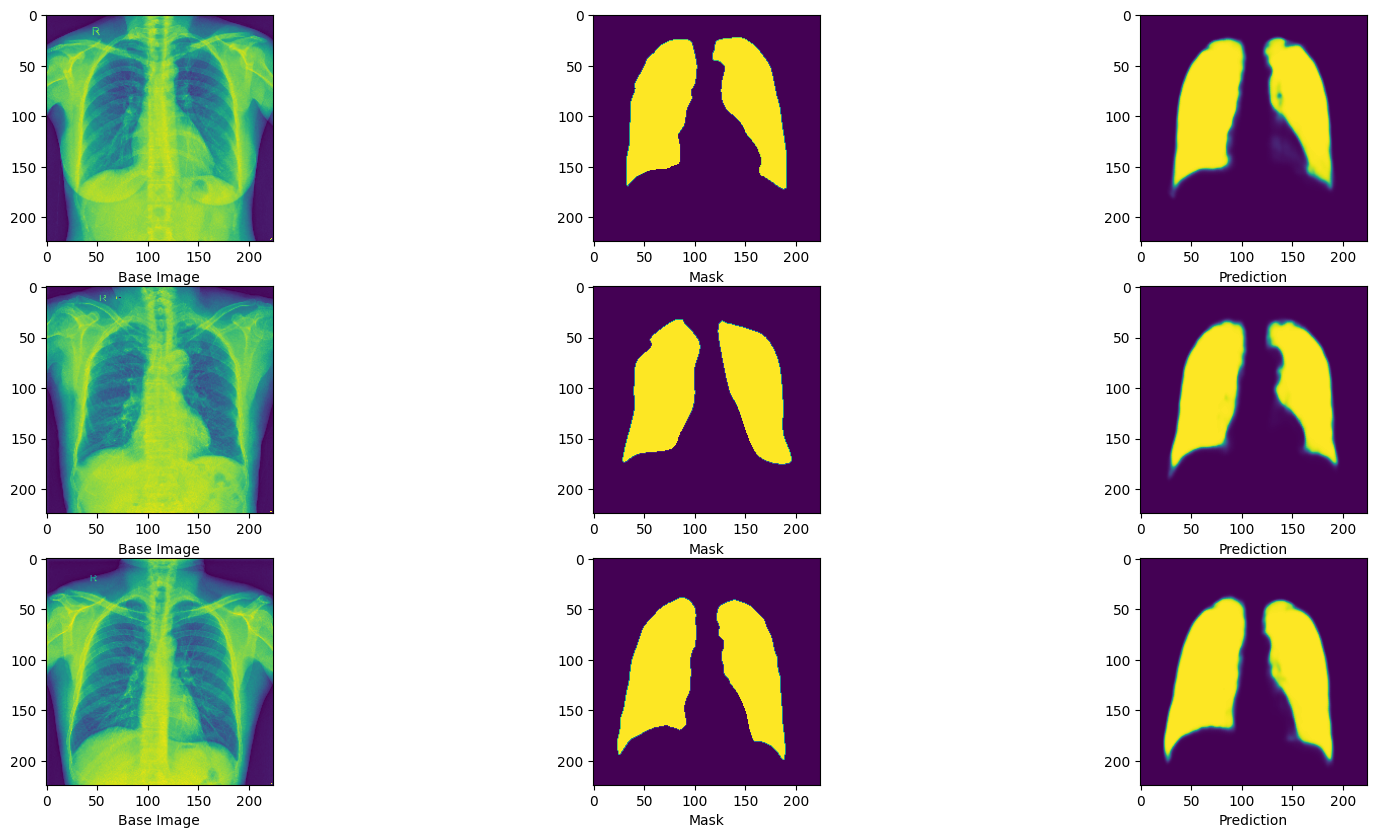

In [39]:
pred_candidates = np.random.randint(1, validation_vol.shape[0], 10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0, 9, 3):
  plt.subplot(3, 3, i+1)

  plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
  plt.xlabel("Base Image")

  plt.subplot(3, 3, i+2)
  plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
  plt.xlabel('Mask')

  plt.subplot(3, 3, i+3)
  plt.imshow(np.squeeze(preds[pred_candidates[i]]))
  plt.xlabel('Prediction')